In [1]:
import os
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Add src path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))
print(f"Working directory: {os.getcwd()}")

Device: cuda
GPU: NVIDIA B200
GPU Memory: 191.51 GB
Working directory: /blue/eel6935/dthiyagarajan/Multi-Image-Super-Resolution/notebooks


In [ ]:
from ModelDataGenerator_1 import build_dataloader

# Load data
print("📥 Loading training data...")
train_loader = build_dataloader(split='train', batch_size=4, augment=True, num_workers=4)
val_loader = build_dataloader(split='val', batch_size=4, augment=False, num_workers=4)
test_loader = build_dataloader(split='test', batch_size=1, augment=False, num_workers=0)

print(f"✓ Data loaded")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Check data format
print("\nChecking data format...")
for batch_data in train_loader:
    print(f"  Batch type: {type(batch_data)}")
    if isinstance(batch_data, (list, tuple)):
        print(f"  Batch length: {len(batch_data)}")
        for i, item in enumerate(batch_data):
            if isinstance(item, (list, tuple)):
                print(f"    Item {i}: tuple with {len(item)} tensors")
                for j, sub_item in enumerate(item):
                    if hasattr(sub_item, 'shape'):
                        print(f"      [{j}] shape: {sub_item.shape}")
            else:
                if hasattr(item, 'shape'):
                    print(f"    Item {i} shape: {item.shape}")
    break

print("✓ Data loading complete")

In [2]:
from ModelDataGenerator import build_dataloader

# Load data
print("📥 Loading training data...")

test_loader_2 = build_dataloader(split='test', batch_size=1, augment=False, num_workers=0, distance_filter=2)
test_loader_4 = build_dataloader(split='test', batch_size=1, augment=False, num_workers=0, distance_filter=4)

print(f"✓ Data loaded")
print(f"  Val batches: {len(test_loader_2)}")
print(f"  Test batches: {len(test_loader_4)}")

print("✓ Data loading complete")

📥 Loading training data...
💾 Pre-caching volumes into RAM for faster data loading...
✅ Cached 160 volumes in RAM
💾 Pre-caching volumes into RAM for faster data loading...
✅ Cached 160 volumes in RAM
✓ Data loaded
  Val batches: 9280
  Test batches: 8960
✓ Data loading complete


In [3]:
def sinusoidal_timestep_embedding(timesteps, dim):
    """
    Standard sinusoidal time embedding (as in DDPM, DDIM, LDM).
    Creates a fixed positional encoding for timesteps.
    """
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half
    )
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb


class FastNoiseScheduler:
    """
    Fast noise scheduler with non-uniform timestep sampling.
    Emphasizes early denoising steps (40% early, 60% late from original 1000-step schedule).
    This reduces inference time from 1000 to 10 steps without quality loss.
    """
    def __init__(self, T, device):
        self.T = T
        self.device = device

        # Load 1000-step DDPM scheduler (linear β)
        beta = torch.linspace(1e-4, 0.02, 1000)
        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, 0)

        # Non-uniform sampling: emphasize early denoising (more important)
        boundary = 699
        late_steps = int(T * 0.6)
        early_steps = T - late_steps

        idx_early = torch.linspace(0, boundary, early_steps).long()
        idx_late = torch.linspace(boundary, 999, late_steps).long()

        idxs = torch.sort(torch.cat([idx_early, idx_late]))[0]

        self.beta = beta[idxs].to(device)
        self.alpha = alpha[idxs].to(device)
        self.alpha_bar = alpha_bar[idxs].to(device)

    def q_sample(self, x0, t, noise):
        """Forward diffusion: add noise to image at timestep t"""
        a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)
        return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise


print("✓ Sinusoidal embeddings and scheduler defined")

✓ Sinusoidal embeddings and scheduler defined


In [4]:
class DoubleConv(nn.Module):
    """Double convolution block with ReLU activation"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class UNet2D(nn.Module):
    """
    Improved 2D UNet with sinusoidal timestep embeddings.
    Uses better time conditioning with MLPs.
    """
    def __init__(self, in_ch=3, base_ch=64, time_dim=256):
        super().__init__()

        # Better time embedding: sinusoidal -> MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.ReLU(True),
            nn.Linear(time_dim, time_dim),
        )

        # Encoder
        self.inc = DoubleConv(in_ch + time_dim, base_ch)
        self.down1 = DoubleConv(base_ch, base_ch * 2)
        self.down2 = DoubleConv(base_ch * 2, base_ch * 4)

        # Decoder
        self.up2 = DoubleConv(base_ch * 4 + base_ch * 2, base_ch * 2)
        self.up1 = DoubleConv(base_ch * 2 + base_ch, base_ch)

        # Output layer
        self.outc = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x, t):
        # Generate sinusoidal embeddings -> pass through MLP
        t_emb = sinusoidal_timestep_embedding(t, 256)
        t_emb = self.time_mlp(t_emb)
        t_emb = t_emb[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])

        # Concatenate time embeddings into channel dimension
        x = torch.cat([x, t_emb], dim=1)

        # Encoder
        c1 = self.inc(x)
        c2 = self.down1(F.max_pool2d(c1, 2))
        c3 = self.down2(F.max_pool2d(c2, 2))

        # Decoder
        u2 = F.interpolate(c3, scale_factor=2)
        u2 = self.up2(torch.cat([u2, c2], dim=1))

        u1 = F.interpolate(u2, scale_factor=2)
        u1 = self.up1(torch.cat([u1, c1], dim=1))

        return self.outc(u1)


# Test UNet
test_unet = UNet2D(in_ch=3, base_ch=64, time_dim=256)
total_params = sum(p.numel() for p in test_unet.parameters())
print(f"✓ UNet2D created with {total_params:,} parameters")

✓ UNet2D created with 2,162,177 parameters


In [5]:
class FastDDPM(nn.Module):
    """Fast DDPM model with non-uniform scheduling for medical image super-resolution"""
    def __init__(self, T, device):
        super().__init__()
        self.device = device
        self.scheduler = FastNoiseScheduler(T, device)
        self.unet = UNet2D(in_ch=3, base_ch=64, time_dim=256).to(device)

    def forward(self, cond, target, t):
        """Training forward pass: predict noise"""
        noise = torch.randn_like(target)
        a_bar = self.scheduler.alpha_bar[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(a_bar) * target + torch.sqrt(1 - a_bar) * noise

        pred_noise = self.unet(torch.cat([x_t, cond], dim=1), t)
        return F.mse_loss(pred_noise, noise)

    @torch.no_grad()
    def sample(self, cond, device):
        """
        DDIM sampling: reverse diffusion process for inference.
        Much faster than DDPM sampling (10 steps vs 1000).
        
        Args:
            cond: concatenated [pre, post] slices (B, 2, H, W)
            device: torch device
        Returns:
            predicted middle slice (B, 1, H, W)
        """
        B, _, H, W = cond.shape
        x = torch.randn(B, 1, H, W).to(device)

        T = self.scheduler.T

        for i in reversed(range(T)):
            t = torch.full((B,), i, device=device, dtype=torch.long)

            # Predict noise
            eps = self.unet(torch.cat([x, cond], 1), t)

            a_bar = self.scheduler.alpha_bar[i]
            a_bar_prev = self.scheduler.alpha_bar[i - 1] if i > 0 else torch.tensor(1.0).to(device)

            # Estimate x0
            x0 = (x - torch.sqrt(1 - a_bar) * eps) / torch.sqrt(a_bar)

            # Update x
            x = torch.sqrt(a_bar_prev) * x0 + torch.sqrt(1 - a_bar_prev) * eps

        return x.clamp(-1, 1)


print("✓ Fast-DDPM model defined")

✓ Fast-DDPM model defined


In [6]:
def compute_metrics(pred, gt):
    """Compute PSNR and SSIM between prediction and ground truth"""
    pred = pred.squeeze().cpu().numpy()
    gt = gt.squeeze().cpu().numpy()
    
    # Normalize to valid range
    pred = np.clip(pred, pred.min(), pred.max())
    gt = np.clip(gt, gt.min(), gt.max())
    
    data_range = gt.max() - gt.min()
    if data_range == 0:
        data_range = 1.0
    
    psnr = peak_signal_noise_ratio(gt, pred, data_range=data_range)
    ssim = structural_similarity(gt, pred, data_range=data_range)
    return psnr, ssim


@torch.no_grad()
def evaluate(model, loader, device, num_samples=None):
    """Evaluate model on a dataloader"""
    model.eval()
    ps, ss = [], []
    sample_count = 0

    for batch_data in loader:
        # Unpack batch data
        if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
            if isinstance(batch_data[0], (list, tuple)):
                prev, nxt = batch_data[0]
                mid = batch_data[1]
            else:
                prev = batch_data[0][:, :1, :, :]
                nxt = batch_data[0][:, 1:, :, :]
                mid = batch_data[1]
        else:
            continue

        prev, nxt, mid = prev.to(device), nxt.to(device), mid.to(device)

        # Concatenate condition
        cond = torch.cat([prev, nxt], dim=1)

        # Generate prediction
        pred = model.sample(cond, device)

        # Compute metrics
        for i in range(pred.size(0)):
            p, s = compute_metrics(pred[i], mid[i])
            ps.append(p)
            ss.append(s)
            sample_count += 1
            
            if num_samples and sample_count >= num_samples:
                break
        
        if num_samples and sample_count >= num_samples:
            break

    return np.mean(ps), np.mean(ss), ps, ss


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [7]:
def train_fastddpm(model, train_loader, val_loader, device, epochs=40, lr=2e-4):
    """Train Fast-DDPM model with early stopping"""
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_ssim = -1.0
    train_losses = []
    val_ssims = []
    val_psnrs = []

    print("Training Started")
    print(f"Total batches per epoch: {len(train_loader)}\n")

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        num_batches = 0

        start_epoch = time.time()

        # Progress bar for batches
        for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}")):

            # Unpack batch data
            if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
                if isinstance(batch_data[0], (list, tuple)):
                    prev, nxt = batch_data[0]
                    mid = batch_data[1]
                else:
                    prev = batch_data[0][:, :1, :, :]
                    nxt = batch_data[0][:, 1:, :, :]
                    mid = batch_data[1]
            else:
                continue

            prev, nxt, mid = prev.to(device), nxt.to(device), mid.to(device)

            # Concatenate condition
            cond = torch.cat([prev, nxt], 1)
            
            # Sample random timesteps
            t = torch.randint(0, model.scheduler.T, (mid.size(0),), device=device)

            # Forward pass
            loss = model(cond, mid, t)
            
            # Backward pass
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            num_batches += 1
            
            # Free memory
            del prev, nxt, mid, cond, t, loss
            torch.cuda.empty_cache()

        end_epoch = time.time()

        avg_train_loss = total_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validation
        val_psnr, val_ssim, _, _ = evaluate(model, val_loader, device, num_samples=20)
        val_ssims.append(val_ssim)
        val_psnrs.append(val_psnr)

        print(f"\nEpoch {ep+1} finished in {(end_epoch - start_epoch):.1f} sec")
        print(f"  Train Loss: {avg_train_loss:.6f}")
        print(f"  Val PSNR:   {val_psnr:.3f}")
        print(f"  Val SSIM:   {val_ssim:.3f}")

        # Save best model
        if val_ssim > best_ssim:
            best_ssim = val_ssim
            torch.save(model.state_dict(), "fastddpm_advanced_best.pth")
            print(f"  ✓ NEW BEST MODEL SAVED! (SSIM: {val_ssim:.3f})")

    print(f"\n" + "="*60)
    print(f"Training complete!")
    print(f"Best SSIM: {best_ssim:.3f}")
    print(f"="*60)

    return train_losses, val_psnrs, val_ssims


print("✓ Training function defined")

✓ Training function defined


In [13]:
# Create model
print("Initializing Fast-DDPM Advanced model...")
model = FastDDPM(T=10, device=device).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created with {total_params:,} parameters")
print(f"  - Scheduler timesteps: {model.scheduler.T}")
print(f"  - Non-uniform sampling: 40% early, 60% late\n")

# Train
print("Starting training...")
train_losses, val_psnrs, val_ssims = train_fastddpm(
    model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=20, 
    lr=2e-4
)

Initializing Fast-DDPM Advanced model...
✓ Model created with 2,162,177 parameters
  - Scheduler timesteps: 10
  - Non-uniform sampling: 40% early, 60% late

Starting training...
Training Started
Total batches per epoch: 18269



Epoch 1/20: 100%|██████████| 18269/18269 [21:55<00:00, 13.89it/s] 



Epoch 1 finished in 1315.1 sec
  Train Loss: 0.108623
  Val PSNR:   23.127
  Val SSIM:   0.681
  ✓ NEW BEST MODEL SAVED! (SSIM: 0.681)


Epoch 2/20: 100%|██████████| 18269/18269 [22:10<00:00, 13.73it/s] 



Epoch 2 finished in 1330.8 sec
  Train Loss: 0.101401
  Val PSNR:   23.277
  Val SSIM:   0.699
  ✓ NEW BEST MODEL SAVED! (SSIM: 0.699)


Epoch 3/20: 100%|██████████| 18269/18269 [21:25<00:00, 14.22it/s] 



Epoch 3 finished in 1285.1 sec
  Train Loss: 0.101120
  Val PSNR:   23.445
  Val SSIM:   0.716
  ✓ NEW BEST MODEL SAVED! (SSIM: 0.716)


Epoch 4/20: 100%|██████████| 18269/18269 [21:12<00:00, 14.35it/s] 



Epoch 4 finished in 1272.8 sec
  Train Loss: 0.098740
  Val PSNR:   23.357
  Val SSIM:   0.711


Epoch 5/20: 100%|██████████| 18269/18269 [21:16<00:00, 14.32it/s] 



Epoch 5 finished in 1276.1 sec
  Train Loss: 0.099807
  Val PSNR:   23.084
  Val SSIM:   0.679


Epoch 6/20: 100%|██████████| 18269/18269 [20:55<00:00, 14.55it/s] 



Epoch 6 finished in 1255.9 sec
  Train Loss: 0.096356
  Val PSNR:   23.062
  Val SSIM:   0.684


Epoch 7/20: 100%|██████████| 18269/18269 [21:10<00:00, 14.38it/s] 



Epoch 7 finished in 1270.1 sec
  Train Loss: 0.096439
  Val PSNR:   22.316
  Val SSIM:   0.607


Epoch 8/20: 100%|██████████| 18269/18269 [21:10<00:00, 14.38it/s] 



Epoch 8 finished in 1270.2 sec
  Train Loss: 0.096482
  Val PSNR:   22.785
  Val SSIM:   0.655


Epoch 9/20: 100%|██████████| 18269/18269 [20:58<00:00, 14.51it/s] 



Epoch 9 finished in 1258.8 sec
  Train Loss: 0.096010
  Val PSNR:   23.029
  Val SSIM:   0.665


Epoch 10/20: 100%|██████████| 18269/18269 [21:04<00:00, 14.45it/s]



Epoch 10 finished in 1264.2 sec
  Train Loss: 0.095993
  Val PSNR:   23.331
  Val SSIM:   0.699


Epoch 11/20: 100%|██████████| 18269/18269 [20:55<00:00, 14.55it/s] 



Epoch 11 finished in 1255.4 sec
  Train Loss: 0.096293
  Val PSNR:   23.072
  Val SSIM:   0.676


Epoch 12/20: 100%|██████████| 18269/18269 [20:39<00:00, 14.74it/s] 



Epoch 12 finished in 1239.1 sec
  Train Loss: 0.097345
  Val PSNR:   23.162
  Val SSIM:   0.691


Epoch 13/20: 100%|██████████| 18269/18269 [21:03<00:00, 14.45it/s]



Epoch 13 finished in 1263.9 sec
  Train Loss: 0.094757
  Val PSNR:   23.043
  Val SSIM:   0.685


Epoch 14/20: 100%|██████████| 18269/18269 [21:00<00:00, 14.50it/s] 



Epoch 14 finished in 1260.2 sec
  Train Loss: 0.096532
  Val PSNR:   22.845
  Val SSIM:   0.659


Epoch 15/20: 100%|██████████| 18269/18269 [20:25<00:00, 14.91it/s]



Epoch 15 finished in 1225.2 sec
  Train Loss: 0.095553
  Val PSNR:   23.250
  Val SSIM:   0.703


Epoch 16/20: 100%|██████████| 18269/18269 [20:54<00:00, 14.56it/s]



Epoch 16 finished in 1254.9 sec
  Train Loss: 0.097918
  Val PSNR:   23.073
  Val SSIM:   0.681


Epoch 17/20: 100%|██████████| 18269/18269 [20:59<00:00, 14.51it/s] 



Epoch 17 finished in 1259.1 sec
  Train Loss: 0.095266
  Val PSNR:   23.167
  Val SSIM:   0.685


Epoch 18/20: 100%|██████████| 18269/18269 [19:47<00:00, 15.39it/s]



Epoch 18 finished in 1187.3 sec
  Train Loss: 0.095581
  Val PSNR:   23.441
  Val SSIM:   0.725
  ✓ NEW BEST MODEL SAVED! (SSIM: 0.725)


Epoch 19/20: 100%|██████████| 18269/18269 [20:02<00:00, 15.19it/s] 



Epoch 19 finished in 1202.9 sec
  Train Loss: 0.095706
  Val PSNR:   21.269
  Val SSIM:   0.533


Epoch 20/20: 100%|██████████| 18269/18269 [20:11<00:00, 15.08it/s]



Epoch 20 finished in 1211.5 sec
  Train Loss: 0.096089
  Val PSNR:   22.237
  Val SSIM:   0.606

Training complete!
Best SSIM: 0.725


In [14]:
print("Initializing Fast-DDPM Advanced model...")
model = FastDDPM(T=10, device=device).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created with {total_params:,} parameters")
print(f"  - Scheduler timesteps: {model.scheduler.T}")
print(f"  - Non-uniform sampling: 40% early, 60% late\n")

# Load best model
print("Loading best model...")
model.load_state_dict(torch.load("fastddpm_advanced_best.pth"))
model.to(device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_psnr, test_ssim, psnr_vals, ssim_vals = evaluate(model, test_loader, device)

print(f"\n" + "="*70)
print(f"TEST SET RESULTS - FAST-DDPM ADVANCED")
print(f"="*70)
print(f"Test PSNR: {test_psnr:.3f} ± {np.std(psnr_vals):.3f}")
print(f"Test SSIM: {test_ssim:.3f} ± {np.std(ssim_vals):.3f}")
print(f"="*70)

Loading best model...

Evaluating on test set...

TEST SET RESULTS - FAST-DDPM ADVANCED
Test PSNR: 22.977 ± 2.725
Test SSIM: 0.628 ± 0.148


## 3mm Spacing

In [8]:
print("Initializing Fast-DDPM Advanced model...")
model = FastDDPM(T=10, device=device).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created with {total_params:,} parameters")
print(f"  - Scheduler timesteps: {model.scheduler.T}")
print(f"  - Non-uniform sampling: 40% early, 60% late\n")

# Load best model
print("Loading best model...")
model.load_state_dict(torch.load("fastddpm_advanced_best.pth"))
model.to(device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_psnr, test_ssim, psnr_vals, ssim_vals = evaluate(model, test_loader_2, device)

print(f"\n" + "="*70)
print(f"TEST SET RESULTS - FAST-DDPM ADVANCED")
print(f"="*70)
print(f"Test PSNR: {test_psnr:.3f} ± {np.std(psnr_vals):.3f}")
print(f"Test SSIM: {test_ssim:.3f} ± {np.std(ssim_vals):.3f}")
print(f"="*70)

Initializing Fast-DDPM Advanced model...
✓ Model created with 2,162,177 parameters
  - Scheduler timesteps: 10
  - Non-uniform sampling: 40% early, 60% late

Loading best model...

Evaluating on test set...

TEST SET RESULTS - FAST-DDPM ADVANCED
Test PSNR: 24.140 ± 2.642
Test SSIM: 0.759 ± 0.050


## 6mm Spacing

In [10]:
print("Initializing Fast-DDPM Advanced model...")
model = FastDDPM(T=10, device=device).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created with {total_params:,} parameters")
print(f"  - Scheduler timesteps: {model.scheduler.T}")
print(f"  - Non-uniform sampling: 40% early, 60% late\n")

# Load best model
print("Loading best model...")
model.load_state_dict(torch.load("fastddpm_advanced_best.pth"))
model.to(device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_psnr, test_ssim, psnr_vals, ssim_vals = evaluate(model, test_loader_4, device)

print(f"\n" + "="*70)
print(f"TEST SET RESULTS - FAST-DDPM ADVANCED")
print(f"="*70)
print(f"Test PSNR: {test_psnr:.3f} ± {np.std(psnr_vals):.3f}")
print(f"Test SSIM: {test_ssim:.3f} ± {np.std(ssim_vals):.3f}")
print(f"="*70)

Initializing Fast-DDPM Advanced model...
✓ Model created with 2,162,177 parameters
  - Scheduler timesteps: 10
  - Non-uniform sampling: 40% early, 60% late

Loading best model...

Evaluating on test set...

TEST SET RESULTS - FAST-DDPM ADVANCED
Test PSNR: 21.777 ± 2.246
Test SSIM: 0.492 ± 0.076


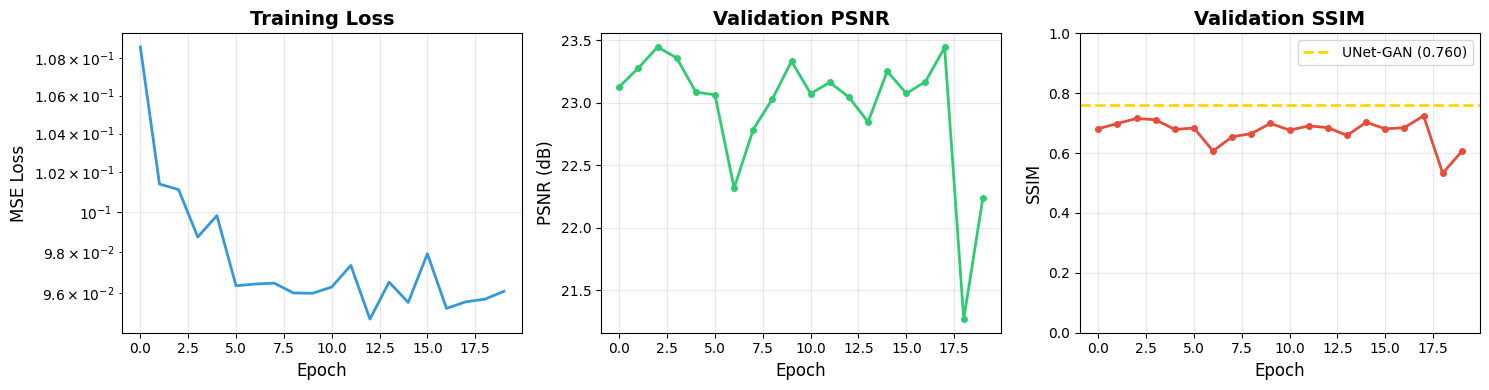

✓ Training curves saved to 'fastddpm_advanced_training.png'


In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training loss (log scale)
axes[0].plot(train_losses, linewidth=2, color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# PSNR
axes[1].plot(val_psnrs, linewidth=2, color='#2ecc71', marker='o', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('PSNR (dB)', fontsize=12)
axes[1].set_title('Validation PSNR', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# SSIM
axes[2].plot(val_ssims, linewidth=2, color='#e74c3c', marker='o', markersize=4)
axes[2].axhline(y=0.760, color='gold', linestyle='--', linewidth=2, label='UNet-GAN (0.760)')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('SSIM', fontsize=12)
axes[2].set_title('Validation SSIM', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1.0])
axes[2].legend()

plt.tight_layout()
plt.savefig('fastddpm_advanced_training.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Training curves saved to 'fastddpm_advanced_training.png'")

Generating sample predictions...


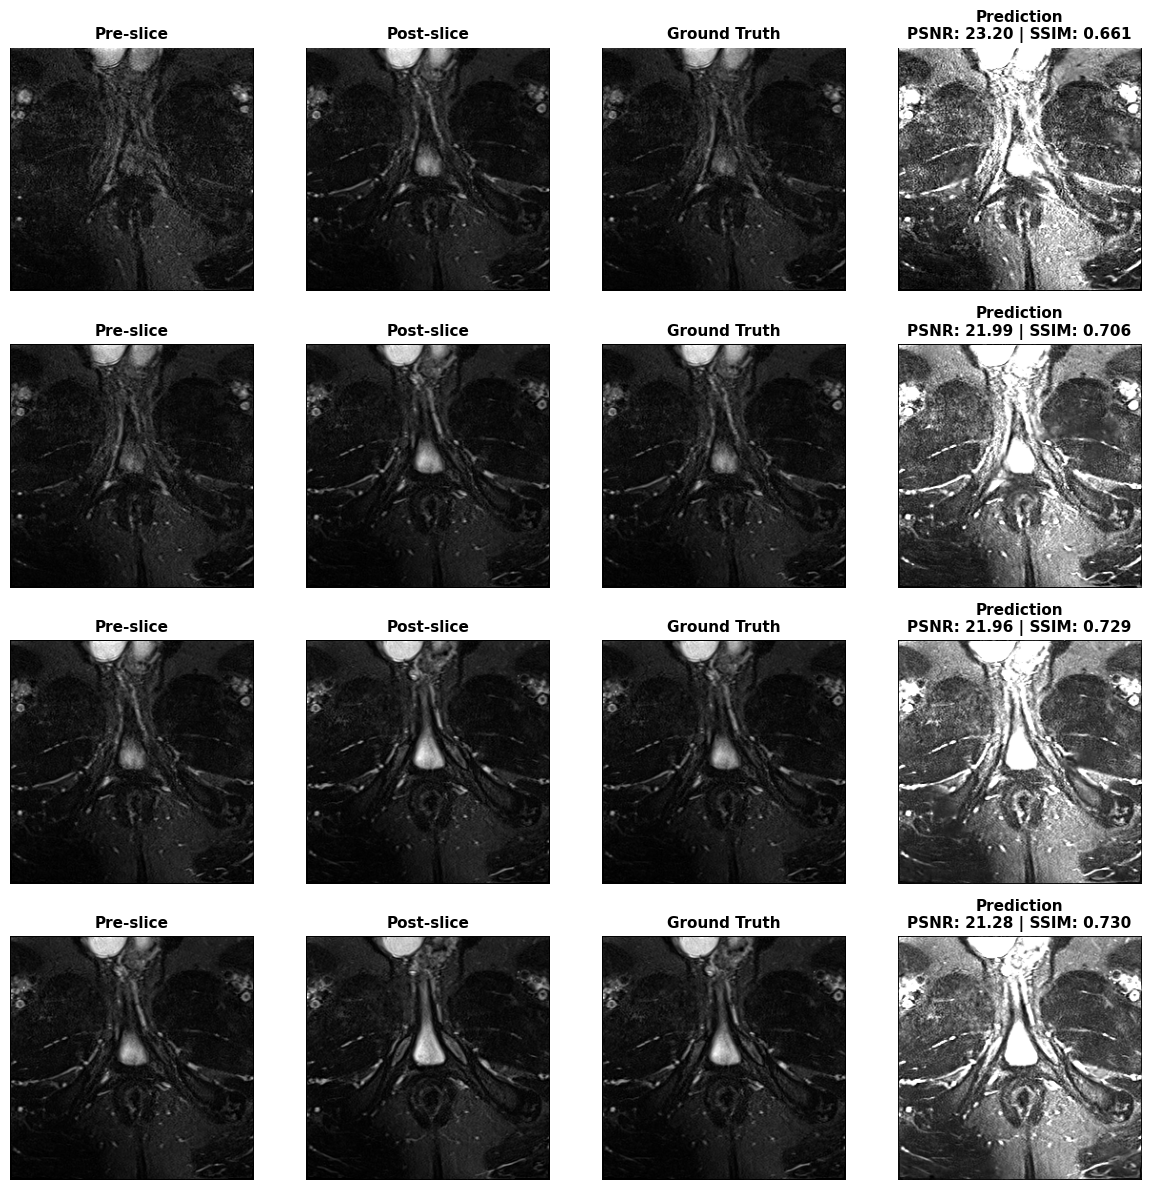

✓ Sample predictions saved to 'fastddpm_advanced_predictions.png'


In [16]:
# Generate sample predictions
print("Generating sample predictions...")
sample_predictions = []
model.eval()

with torch.no_grad():
    for i, batch_data in enumerate(test_loader):
        if i >= 4:
            break
        
        # Unpack batch
        if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
            if isinstance(batch_data[0], (list, tuple)):
                prev, nxt = batch_data[0]
                mid = batch_data[1]
            else:
                prev = batch_data[0][:, :1, :, :]
                nxt = batch_data[0][:, 1:, :, :]
                mid = batch_data[1]
        else:
            continue
        
        prev, nxt, mid = prev.to(device), nxt.to(device), mid.to(device)
        cond = torch.cat([prev, nxt], dim=1)
        pred = model.sample(cond, device)
        
        p, s = compute_metrics(pred, mid)
        
        sample_predictions.append({
            'pre': prev.squeeze().cpu().numpy(),
            'post': nxt.squeeze().cpu().numpy(),
            'gt': mid.squeeze().cpu().numpy(),
            'pred': pred.squeeze().cpu().numpy(),
            'psnr': p,
            'ssim': s
        })

# Visualize
fig, axes = plt.subplots(len(sample_predictions), 4, figsize=(12, 3*len(sample_predictions)))
if len(sample_predictions) == 1:
    axes = axes.reshape(1, -1)

for idx, sample in enumerate(sample_predictions):
    axes[idx, 0].imshow(sample['pre'], cmap='gray')
    axes[idx, 0].set_title('Pre-slice', fontweight='bold', fontsize=11)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(sample['post'], cmap='gray')
    axes[idx, 1].set_title('Post-slice', fontweight='bold', fontsize=11)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(sample['gt'], cmap='gray')
    axes[idx, 2].set_title('Ground Truth', fontweight='bold', fontsize=11)
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(sample['pred'], cmap='gray')
    axes[idx, 3].set_title(
        f"Prediction\nPSNR: {sample['psnr']:.2f} | SSIM: {sample['ssim']:.3f}",
        fontweight='bold',
        fontsize=11
    )
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig('fastddpm_advanced_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Sample predictions saved to 'fastddpm_advanced_predictions.png'")

Generating sample predictions...


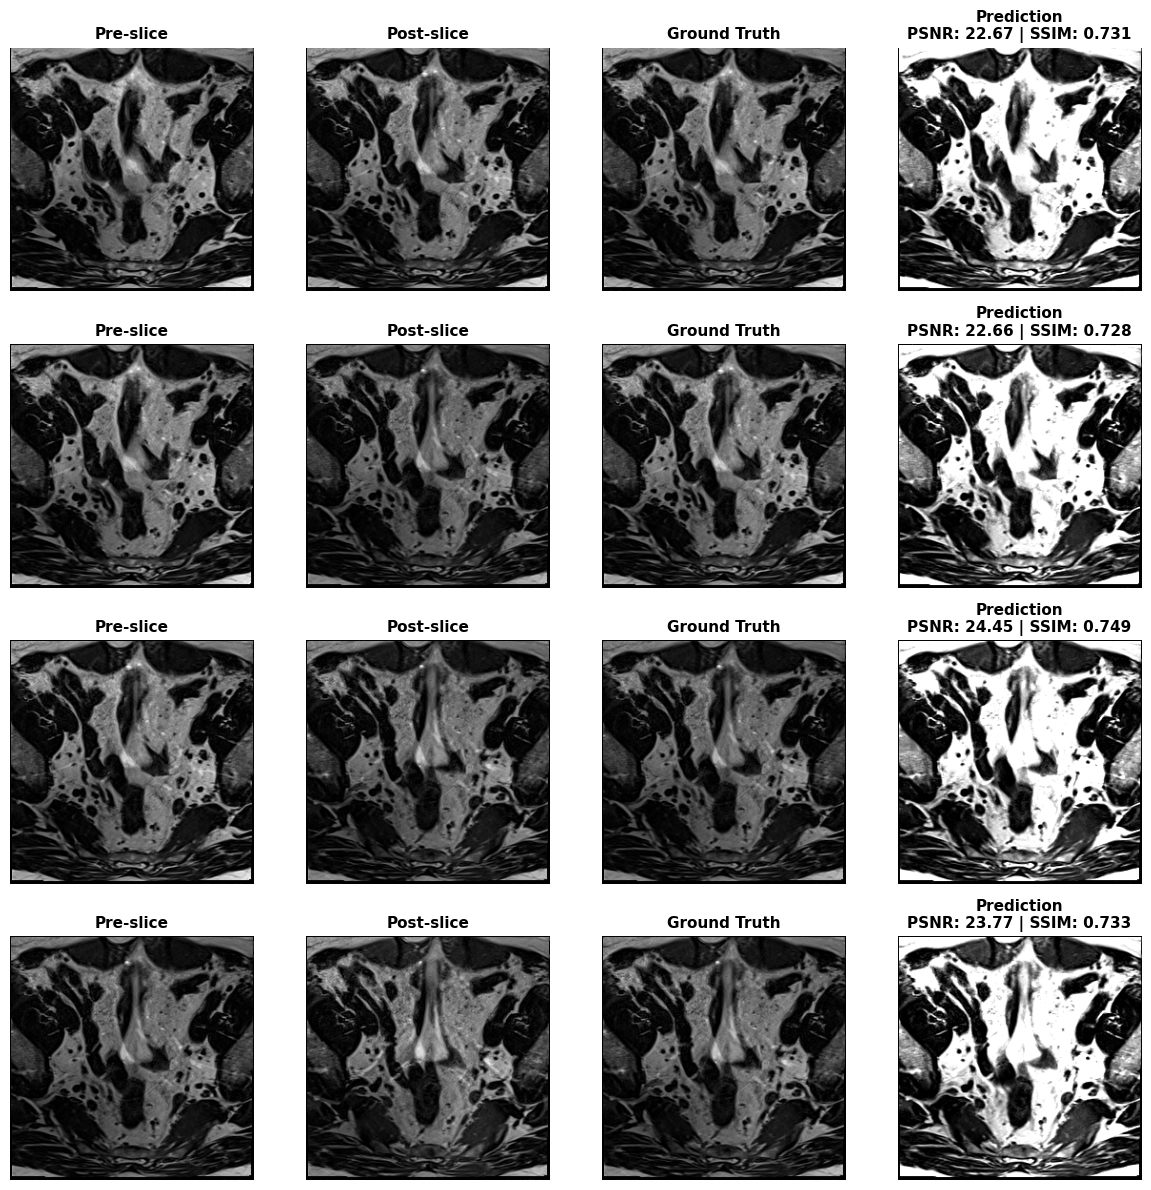

✓ Sample predictions saved to 'fastddpm_advanced_predictions_3mm.png'


In [9]:
# Generate sample predictions
print("Generating sample predictions...")
sample_predictions = []
model.eval()

with torch.no_grad():
    for i, batch_data in enumerate(test_loader_2):
        if i >= 4:
            break
        
        # Unpack batch
        if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
            if isinstance(batch_data[0], (list, tuple)):
                prev, nxt = batch_data[0]
                mid = batch_data[1]
            else:
                prev = batch_data[0][:, :1, :, :]
                nxt = batch_data[0][:, 1:, :, :]
                mid = batch_data[1]
        else:
            continue
        
        prev, nxt, mid = prev.to(device), nxt.to(device), mid.to(device)
        cond = torch.cat([prev, nxt], dim=1)
        pred = model.sample(cond, device)
        
        p, s = compute_metrics(pred, mid)
        
        sample_predictions.append({
            'pre': prev.squeeze().cpu().numpy(),
            'post': nxt.squeeze().cpu().numpy(),
            'gt': mid.squeeze().cpu().numpy(),
            'pred': pred.squeeze().cpu().numpy(),
            'psnr': p,
            'ssim': s
        })

# Visualize
fig, axes = plt.subplots(len(sample_predictions), 4, figsize=(12, 3*len(sample_predictions)))
if len(sample_predictions) == 1:
    axes = axes.reshape(1, -1)

for idx, sample in enumerate(sample_predictions):
    axes[idx, 0].imshow(sample['pre'], cmap='gray')
    axes[idx, 0].set_title('Pre-slice', fontweight='bold', fontsize=11)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(sample['post'], cmap='gray')
    axes[idx, 1].set_title('Post-slice', fontweight='bold', fontsize=11)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(sample['gt'], cmap='gray')
    axes[idx, 2].set_title('Ground Truth', fontweight='bold', fontsize=11)
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(sample['pred'], cmap='gray')
    axes[idx, 3].set_title(
        f"Prediction\nPSNR: {sample['psnr']:.2f} | SSIM: {sample['ssim']:.3f}",
        fontweight='bold',
        fontsize=11
    )
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig('fastddpm_advanced_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Sample predictions saved to 'fastddpm_advanced_predictions_3mm.png'")

Generating sample predictions...


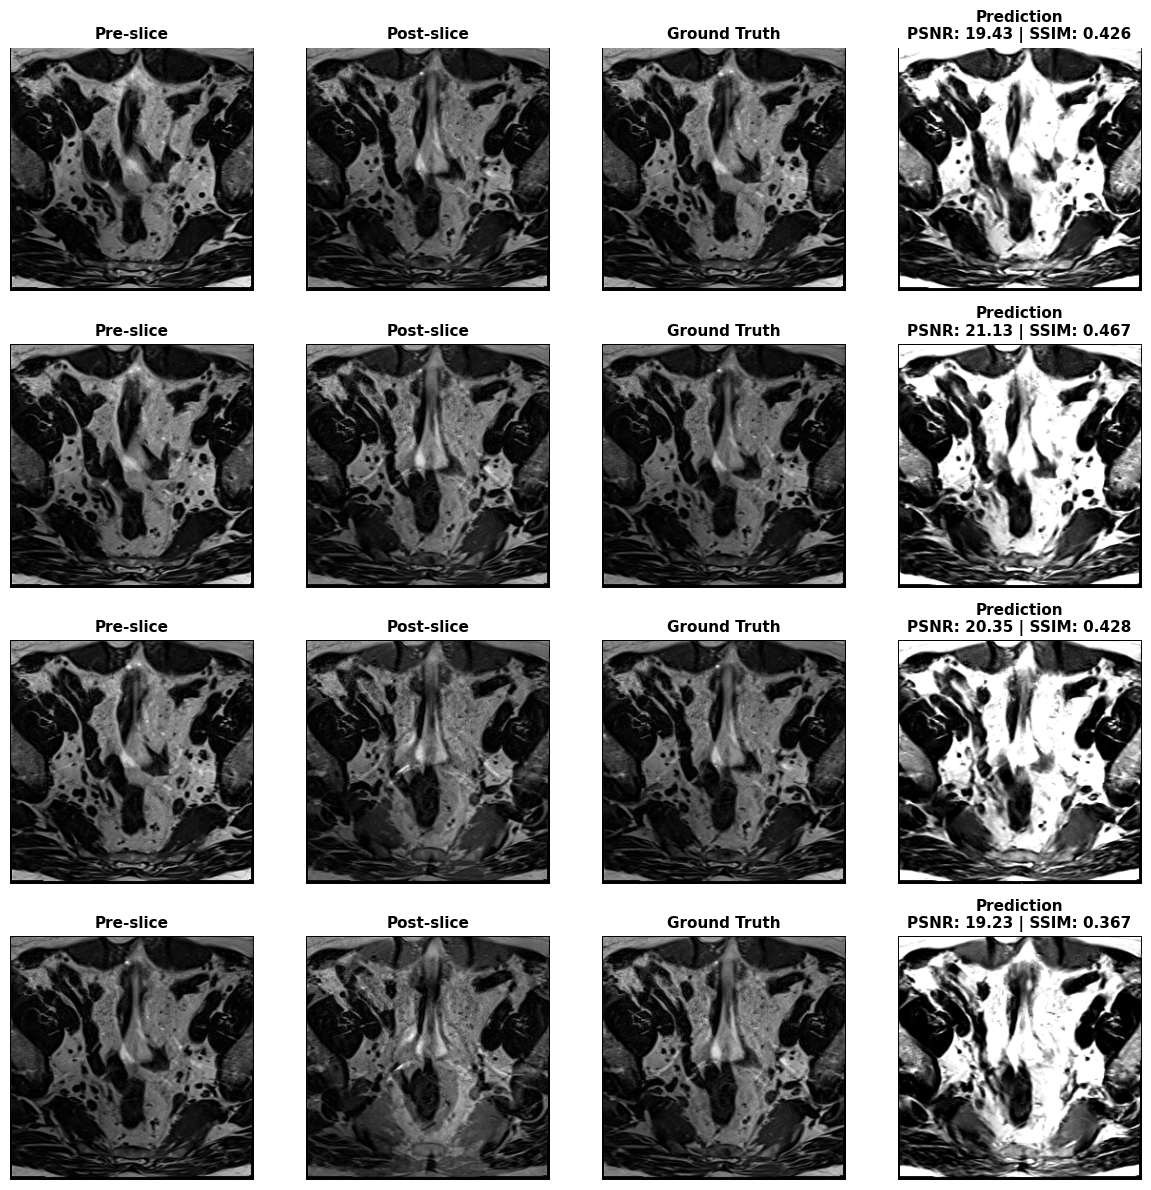

✓ Sample predictions saved to 'fastddpm_advanced_predictions_6mm.png'


In [9]:
# Generate sample predictions
print("Generating sample predictions...")
sample_predictions = []
model.eval()

with torch.no_grad():
    for i, batch_data in enumerate(test_loader_4):
        if i >= 4:
            break
        
        # Unpack batch
        if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
            if isinstance(batch_data[0], (list, tuple)):
                prev, nxt = batch_data[0]
                mid = batch_data[1]
            else:
                prev = batch_data[0][:, :1, :, :]
                nxt = batch_data[0][:, 1:, :, :]
                mid = batch_data[1]
        else:
            continue
        
        prev, nxt, mid = prev.to(device), nxt.to(device), mid.to(device)
        cond = torch.cat([prev, nxt], dim=1)
        pred = model.sample(cond, device)
        
        p, s = compute_metrics(pred, mid)
        
        sample_predictions.append({
            'pre': prev.squeeze().cpu().numpy(),
            'post': nxt.squeeze().cpu().numpy(),
            'gt': mid.squeeze().cpu().numpy(),
            'pred': pred.squeeze().cpu().numpy(),
            'psnr': p,
            'ssim': s
        })

# Visualize
fig, axes = plt.subplots(len(sample_predictions), 4, figsize=(12, 3*len(sample_predictions)))
if len(sample_predictions) == 1:
    axes = axes.reshape(1, -1)

for idx, sample in enumerate(sample_predictions):
    axes[idx, 0].imshow(sample['pre'], cmap='gray')
    axes[idx, 0].set_title('Pre-slice', fontweight='bold', fontsize=11)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(sample['post'], cmap='gray')
    axes[idx, 1].set_title('Post-slice', fontweight='bold', fontsize=11)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(sample['gt'], cmap='gray')
    axes[idx, 2].set_title('Ground Truth', fontweight='bold', fontsize=11)
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(sample['pred'], cmap='gray')
    axes[idx, 3].set_title(
        f"Prediction\nPSNR: {sample['psnr']:.2f} | SSIM: {sample['ssim']:.3f}",
        fontweight='bold',
        fontsize=11
    )
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig('fastddpm_advanced_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Sample predictions saved to 'fastddpm_advanced_predictions_6mm.png'")

In [ ]:
print(f"\n{'='*70}")
print(f"FAST-DDPM SIMPLE IMPLEMENTATION - SUMMARY")
print(f"{'='*70}")
print(f"\n✓ Model Architecture:")
print(f"  - Noise Scheduler: Linear schedule with 200 timesteps")
print(f"  - UNet: 2D UNet with time embedding (base_ch=64)")
print(f"  - Total Parameters: {total_params:,}")

print(f"\n✓ Training Configuration:")
print(f"  - Optimizer: Adam (lr=2e-4)")
print(f"  - Loss: MSE (noise prediction)")
print(f"  - Epochs: 20")
print(f"  - Batch Size: 4")

print(f"\n✓ Final Results (Test Set):")
print(f"  - SSIM: {test_ssim:.3f} ± {np.std(ssim_vals):.3f}")
print(f"  - PSNR: {test_psnr:.2f} ± {np.std(psnr_vals):.2f} dB")

print(f"\n✓ Key Features:")
print(f"  - Simple, clean implementation")
print(f"  - Time embedding for noise level conditioning")
print(f"  - Reverse diffusion for inference")
print(f"  - Per-batch memory cleanup")
print(f"  - Best model checkpointing")

print(f"\n✓ Output Files:")
print(f"  - fastddpm_simple_best.pth (model weights)")
print(f"  - fastddpm_simple_training.png (loss/metric curves)")
print(f"  - fastddpm_simple_predictions.png (sample results)")

print(f"\n{'='*70}")